## Load and Prep

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
from collections import Counter
from scipy import stats
#from plotnine import *
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.weightstats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False) #expands columns in pandas removing truncation

df = pd.read_csv(r'C:\Users\jason\Desktop\vgsales.csv')
col_names = df.columns

# Remove unwanted columns
df = df[['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Release_Date']]

# import ign df with scores
ign = pd.read_csv(r'C:\Users\jason\Desktop\ign.csv')
ign = ign[['title', 'platform', 'score', 'editors_choice', 'release_year', 'release_month', 'release_day']]

# Rename date columns to capital for consistency
ign.rename(columns={'release_year': 'Release_Year', 'release_month': 'Release_Month', 'release_day': 'Release_Day'},
           inplace=True)


# Fix platform data in ign so it matches that in games df
consoles_ign = ['NES', 'Super NES', 'Nintendo 64', 'GameCube', 'Wii', 'Wii U', 'NS', 'Game Boy', 'Game Boy Color',
                'Game Boy Advance', 'Game Gear', 'Nintendo DS', 'Nintendo 3DS', 'PlayStation', 'PlayStation 2', 'PlayStation 3',
                'PlayStation 4', 'PlayStation Portable', 'PlayStation Vita', 'Xbox', 'Xbox 360', 'Xbox One', 'Genesis', 'Dreamcast']

consoles_games = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBC', 'GBA', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']



ign = ign.replace(to_replace=consoles_ign, value=consoles_games)


# ~~~~~~~~~PLATFORM~~~~~~~~~~

# Looking at the different types of Platforms to remove unnecessary ones (nobody cares about the commodore 64 from '85)
df.Platform.value_counts(dropna=False)


consoles = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']


# Removes all rows NOT associated with the above consoles and makes new db, games, by merging
vgsales = df[df['Platform'].isin(consoles)]
ign = ign[ign['platform'].isin(consoles)]


# join the two dfs based on game name (and add platform)
games = pd.merge(vgsales, ign, left_on=['Name', 'Platform'], right_on=['title', 'platform'], how='left')




# Fixing Sales columns (removing m)
games.Global_Sales = games.Global_Sales.str.replace('m', '')
games.NA_Sales = games.NA_Sales.str.replace('m', '')
games.PAL_Sales = games.PAL_Sales.str.replace('m', '')
games.JP_Sales = games.JP_Sales.str.replace('m', '')
games.Other_Sales = games.Other_Sales.str.replace('m', '')

# Splitting Release_Date into Day/Month/Year
games['Day'] = games.Release_Date.str[0:2]
games['Month'] = games.Release_Date.str[5:8]
games['Year'] = games.Release_Date.str[9:]

# Converting to appropriate data types
games.Genre = games.Genre.astype('category')
games.Name = games.Name.astype('str')
games.Platform = games.Platform.astype('category')
games.Publisher = games.Publisher.astype('category')
games.Developer = games.Developer.astype('category')
games.Global_Sales = games.Global_Sales.astype('float')
games.NA_Sales = games.NA_Sales.astype('float')
games.PAL_Sales = games.PAL_Sales.astype('float')
games.JP_Sales = games.JP_Sales.astype('float')
games.Other_Sales = games.Other_Sales.astype('float')
games.title = games.title.astype('str')
games.platform = games.platform.astype('category')
games.editors_choice = games.editors_choice.astype('category')



# Converting to Datetime
games.Release_Date = games.Month + '/' + games.Day + '/' + games.Year.astype('str') #combine to single column
games.Release_Date = [None if pd.isnull(dates) else datetime.strptime(str(dates), '%b/%d/%y') for dates in games.Release_Date]

# Remove titles with 1970 release dates (wrong)
games = games[games['Release_Date'].dt.year >= 1980]

# Fixing titles discovered incorrect dates
# check on "A value is trying to be set on a copy of a slice"
games.loc[[21278], 'Release_Date'] = games.loc[21278, 'Release_Date'].replace(2003)
games.loc[[2232], 'Release_Date'] = games.loc[2232, 'Release_Date'].replace(2010)
games.loc[[11572], 'Release_Date'] = games.loc[11572, 'Release_Date'].replace(2007)
games.loc[[17935], 'Release_Date'] = games.loc[17935, 'Release_Date'].replace(2008)
games.loc[[25883], 'Release_Date'] = games.loc[25883, 'Release_Date'].replace(2009)
games.loc[[15941], 'Release_Date'] = games.loc[15941, 'Release_Date'].replace(2006)
games.loc[[22295], 'Release_Date'] = games.loc[22295, 'Release_Date'].replace(2007)
games.loc[[1005], 'Release_Date'] = games.loc[1005, 'Release_Date'].replace(2012)
games.loc[[1751], 'Release_Date'] = games.loc[1751, 'Release_Date'].replace(2009)
games.loc[[10413], 'Release_Date'] = games.loc[10413, 'Release_Date'].replace(2013)
games.loc[[19837], 'Release_Date'] = games.loc[19837, 'Release_Date'].replace(2006)
games.loc[[21229], 'Release_Date'] = games.loc[21229, 'Release_Date'].replace(2011)
games.loc[[21763], 'Release_Date'] = games.loc[21763, 'Release_Date'].replace(2011)
games.loc[[2012], 'Release_Date'] = games.loc[2012, 'Release_Date'].replace(2011)
games.loc[[11368], 'Release_Date'] = games.loc[11368, 'Release_Date'].replace(2014)
games.loc[[5363], 'Release_Date'] = games.loc[5363, 'Release_Date'].replace(2000)
games.loc[[6033], 'Release_Date'] = games.loc[6033, 'Release_Date'].replace(2001)
games.loc[[6033], 'Release_Date'] = games.loc[6033, 'Release_Date'].replace(2001)



# Find other titles with improper release and no info, as discovered (never released, cancelled, etc)
consoles = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']
begin = [1983, 1990, 1996, 2001, 2006, 2012, 2017, 1989, 2001, 1998, 1990, 2004, 2011, 1994, 2000,
            2006, 2013, 2005, 2011, 2001, 2005, 2013, 1988, 1998]
end = [1995, 1999, 2002, 2007, 2017, 2018, 2020, 2003, 2008, 2003, 1997, 2016, 2020, 2006, 2013,
            2017, 2020, 2016, 2020, 2009, 2017, 2020, 1999, 2001]
life = [j - i for i, j in zip(begin, end)]


systems_info = pd.DataFrame({'Consoles': consoles,
                             'Start': begin,
                             'Discontinued': end,
                             'Lifespan': life})

systems_info = systems_info.sort_values('Start')
systems_info = systems_info.reset_index(inplace=False)
systems_info = systems_info.drop('index', axis=1)



# Create General categories Nintendo, Sony, Microsoft etc
company = [] # initialize a list

# List of platforms to define each company
Nintendo = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'DS', '3DS']
Microsoft = ['XB', 'X360', 'XOne']
Sony = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
Sega = ['GEN', 'DC', 'GG']


# Loop over platforms to fill company list up and add it to games df
for i in games.Platform:
    if i in Sony:
        company.append('Sony')
    elif i in Nintendo:
        company.append('Nintendo')
    elif i in Microsoft:
        company.append('Microsoft')
    else:
        company.append('Sega')

games['Company'] = company




# Create df's for each system with erroneous dates to fix as needed
bad_NES = games.loc[((games['Release_Date'].dt.year < begin[0]) | (games['Release_Date'].dt.year > end[0]))
                      & (games['Platform'] == consoles[0])]
bad_SNES = games.loc[((games['Release_Date'].dt.year < begin[1]) | (games['Release_Date'].dt.year > end[1]))
                      & (games['Platform'] == consoles[1])]
bad_N64 = games.loc[((games['Release_Date'].dt.year < begin[2]) | (games['Release_Date'].dt.year > end[2]))
                      & (games['Platform'] == consoles[2])]
bad_GC = games.loc[((games['Release_Date'].dt.year < begin[3]) | (games['Release_Date'].dt.year > end[3]))
                      & (games['Platform'] == consoles[3])]
bad_Wii = games.loc[((games['Release_Date'].dt.year < begin[4]) | (games['Release_Date'].dt.year > end[4]))
                      & (games['Platform'] == consoles[4])]
bad_WiiU = games.loc[((games['Release_Date'].dt.year < begin[5]) | (games['Release_Date'].dt.year > end[5]))
                      & (games['Platform'] == consoles[5])]
bad_NS = games.loc[((games['Release_Date'].dt.year < begin[6]) | (games['Release_Date'].dt.year > end[6]))
                      & (games['Platform'] == consoles[6])]
bad_GB = games.loc[((games['Release_Date'].dt.year < begin[7]) | (games['Release_Date'].dt.year > end[7]))
                      & (games['Platform'] == consoles[7])]
bad_GBA = games.loc[((games['Release_Date'].dt.year < begin[8]) | (games['Release_Date'].dt.year > end[8]))
                      & (games['Platform'] == consoles[8])]
bad_GBC = games.loc[((games['Release_Date'].dt.year < begin[9]) | (games['Release_Date'].dt.year > end[9]))
                      & (games['Platform'] == consoles[9])]
bad_GG = games.loc[((games['Release_Date'].dt.year < begin[10]) | (games['Release_Date'].dt.year > end[10]))
                      & (games['Platform'] == consoles[10])]
bad_DS = games.loc[((games['Release_Date'].dt.year < begin[11]) | (games['Release_Date'].dt.year > end[11]))
                      & (games['Platform'] == consoles[11])]
bad_3DS = games.loc[((games['Release_Date'].dt.year < begin[12]) | (games['Release_Date'].dt.year > end[12]))
                      & (games['Platform'] == consoles[12])]
bad_PS = games.loc[((games['Release_Date'].dt.year < begin[13]) | (games['Release_Date'].dt.year > end[13]))
                      & (games['Platform'] == consoles[13])]
bad_PS2 = games.loc[((games['Release_Date'].dt.year < begin[14]) | (games['Release_Date'].dt.year > end[14]))
                      & (games['Platform'] == consoles[14])]
bad_PS3 = games.loc[((games['Release_Date'].dt.year < begin[15]) | (games['Release_Date'].dt.year > end[15]))
                      & (games['Platform'] == consoles[15])]
bad_PS4 = games.loc[((games['Release_Date'].dt.year < begin[16]) | (games['Release_Date'].dt.year > end[16]))
                      & (games['Platform'] == consoles[16])]
bad_PSP = games.loc[((games['Release_Date'].dt.year < begin[7]) | (games['Release_Date'].dt.year > end[17]))
                      & (games['Platform'] == consoles[17])]
bad_PSV = games.loc[((games['Release_Date'].dt.year < begin[18]) | (games['Release_Date'].dt.year > end[18]))
                      & (games['Platform'] == consoles[18])]
bad_XB = games.loc[((games['Release_Date'].dt.year < begin[19]) | (games['Release_Date'].dt.year > end[19]))
                      & (games['Platform'] == consoles[19])]
bad_X360 = games.loc[((games['Release_Date'].dt.year < begin[20]) | (games['Release_Date'].dt.year > end[20]))
                      & (games['Platform'] == consoles[20])]
bad_XOne = games.loc[((games['Release_Date'].dt.year < begin[21]) | (games['Release_Date'].dt.year > end[21]))
                      & (games['Platform'] == consoles[21])]
bad_GEN = games.loc[((games['Release_Date'].dt.year < begin[22]) | (games['Release_Date'].dt.year > end[22]))
                      & (games['Platform'] == consoles[22])]
bad_DC = games.loc[((games['Release_Date'].dt.year < begin[23]) | (games['Release_Date'].dt.year > end[23]))
                      & (games['Platform'] == consoles[23])]
bad_DC.drop(24721, inplace=True) # drop value that actually was released outside of release date so not removed below

# Fix the two missing values for developers
games[games['Developer'].isnull()]
games.loc[[10489], 'Developer'] = 'Ubisoft'
games.loc[[31225], 'Developer'] = 'Unknown'

# Drop games with no info and bad dates (assume never released) 246 games
games = games.drop(bad_NES.index.values)
games = games.drop(bad_SNES.index.values)
games = games.drop(bad_GC.index.values)
games = games.drop(bad_Wii.index.values)
games = games.drop(bad_WiiU.index.values)
games = games.drop(bad_GB.index.values)
games = games.drop(bad_GBA.index.values)
games = games.drop(bad_DS.index.values)
games = games.drop(bad_3DS.index.values)
games = games.drop(bad_PS.index.values)
games = games.drop(bad_PS2.index.values)
games = games.drop(bad_PS3.index.values)
games = games.drop(bad_PSP.index.values)
games = games.drop(bad_X360.index.values)
games = games.drop(bad_GEN.index.values)
games = games.drop(bad_DC.index.values)

# Drop all games missing global sales values pre 2018 (not games to predict)
todrop = games[games['Global_Sales'].isnull() & (games['Release_Date'].dt.year < 2018)]
games = games.drop(todrop.index)


# Clean up missing dates
games.Release_Year = games.Release_Date.dt.year
games.Release_Month = games.Release_Date.dt.month
games.Release_Day = games.Release_Date.dt.day


# Check on number of missing values
games.isnull().sum()


# Assign a numeric value for the order of games' release to simulate time progression
games = games.sort_values(['Release_Date']) #.reset_index(drop=True)
games['Order'] = list(range(len(games)))
games = games.sort_index()




a = games



# Quick simple hypothesis test:
# It appears like Nintendo sells better, is that true?

# H0: Nintendo based mean game sales is the same as Sony based mean game sales (μn = μs)
# Ha: Nintendo based mean game sales is  not the same as Sony based mean game sale (μn != μs)
# alpha = 0.05

nintendo = games[games['Company'] == 'Nintendo']
nintendo = nintendo.dropna(subset=['Global_Sales'])
sony = games[games['Company'] == 'Sony']
sony = sony.dropna(subset=['Global_Sales'])


# Histogram
sns.distplot(nintendo.Global_Sales, bins=3000)
plt.xlim(0, 2)
plt.xlabel('Global Sales')
plt.ylabel('Count')
plt.title('Nintendo Sales')
plt.legend(loc='upper right')
plt.show()

sns.distplot(sony.Global_Sales, bins=1000)
plt.xlim(0, 2)
plt.xlabel('Global Sales')
plt.ylabel('Count')
plt.title('Sony Sales')
plt.show()

hyp = statsmodels.stats.weightstats.ztest(nintendo.Global_Sales, sony.Global_Sales)
print('t =', round(hyp[0], 3))
print('p-value =', round(hyp[1], 3))
print('p-value much greater than alpha, so we cannot reject the null hypothesis and Nintendo did not make significantly more sales')

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

t = 0.6
p-value = 0.548
p-value much greater than alpha, so we cannot reject the null hypothesis and Nintendo did not make significantly more sales


## EDA

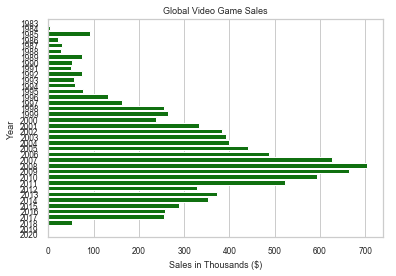

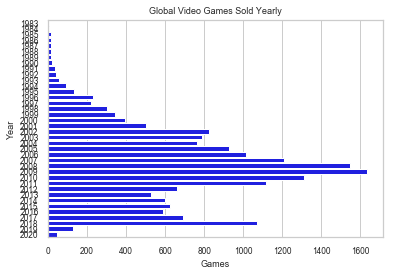

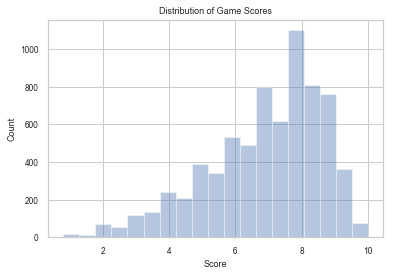

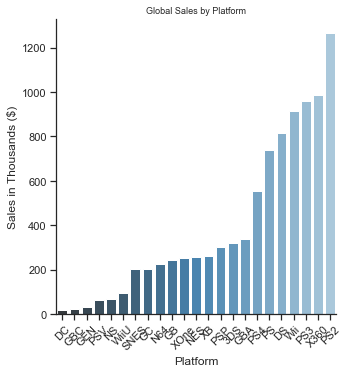

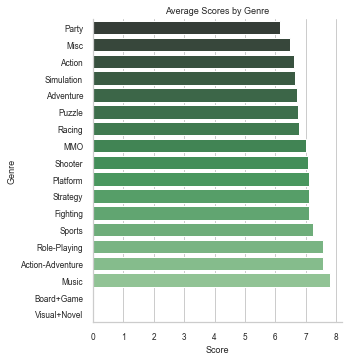

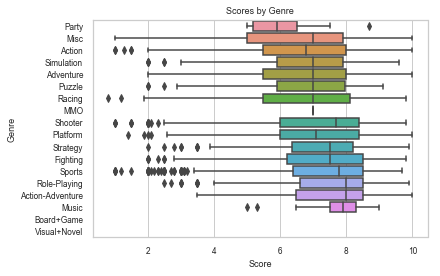

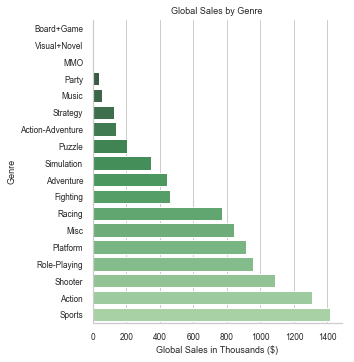

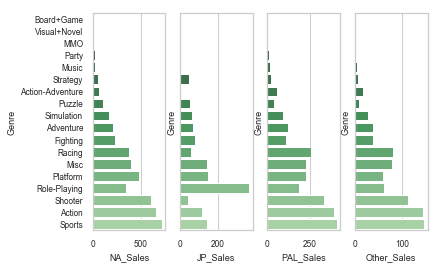

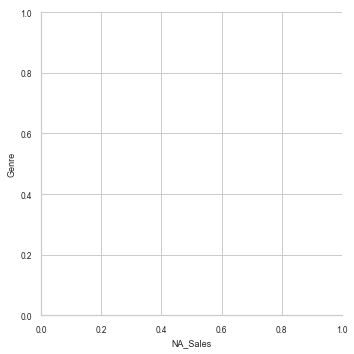

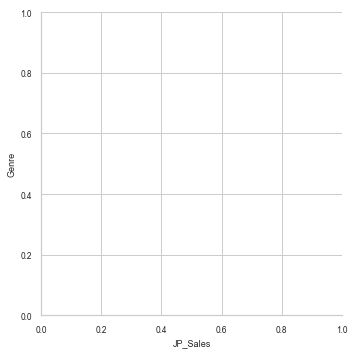

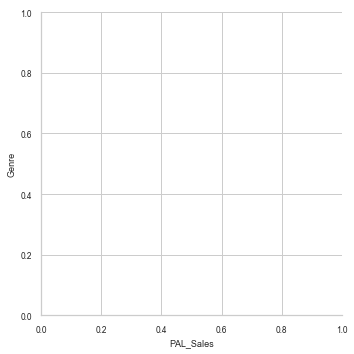

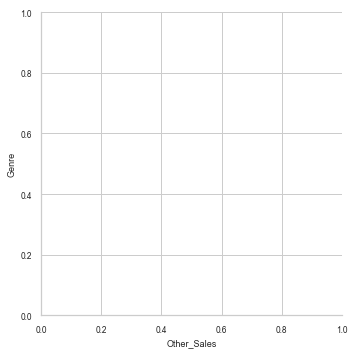

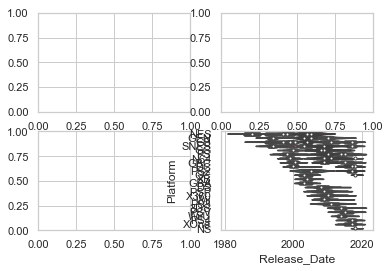

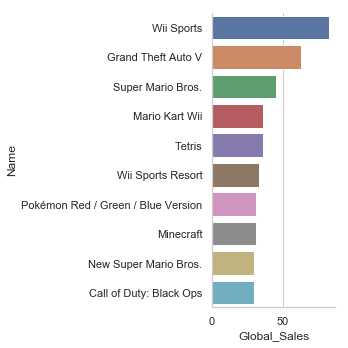

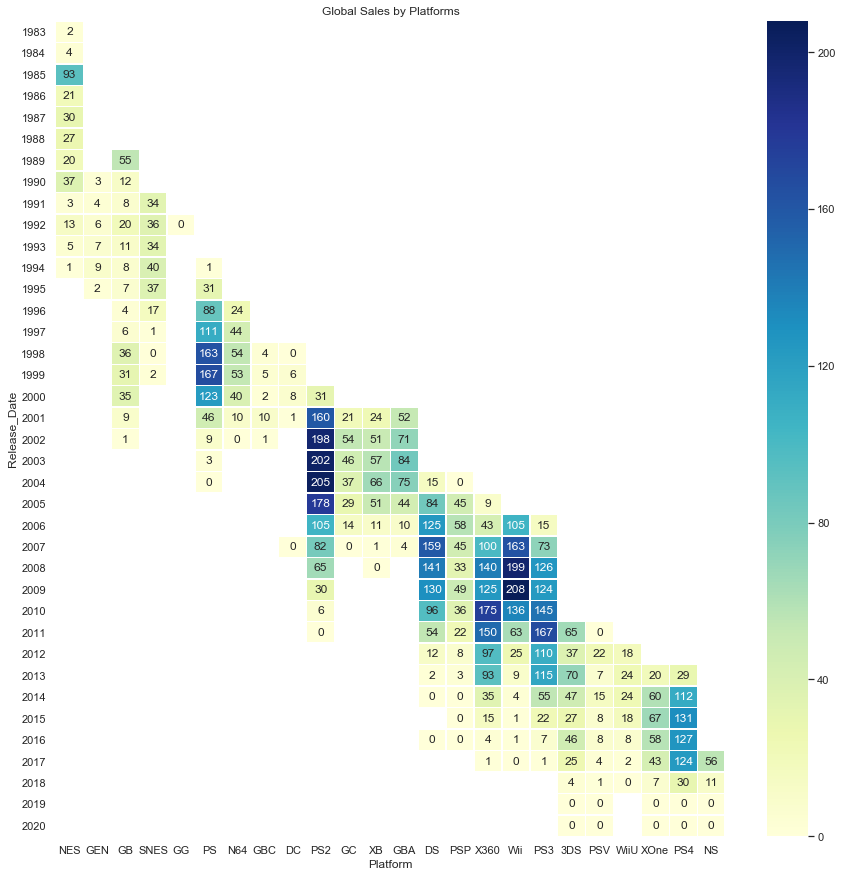

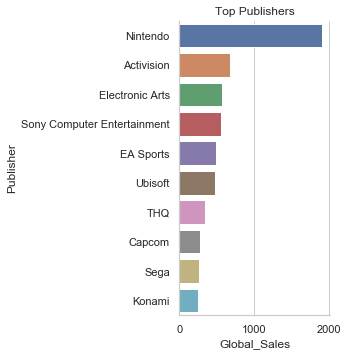

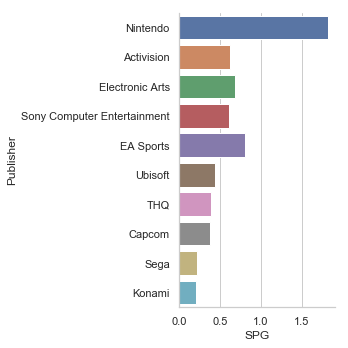

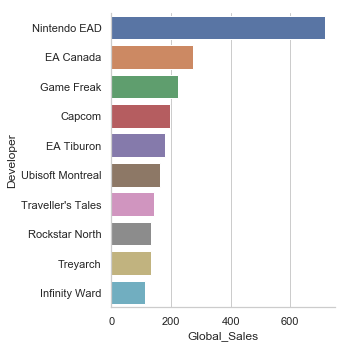

In [600]:



# ~~~~~~~~~~~EDA~~~~~~~~~~~~~~~
# game sales by year
by_year = games.groupby(by=games['Release_Date'].dt.year).sum()
by_year.reset_index(inplace=True)
sns.set(style='whitegrid', font_scale=0.75)
gsby = sns.barplot(x='Global_Sales', y='Release_Date', data=by_year, orient='h', color='green').set_title('Global Video Game Sales')
plt.xlabel('Sales in Thousands ($)')
plt.ylabel('Year')
plt.show()



# number of games released each year
sns.set(style='whitegrid', font_scale=0.75)
gpy = sns.countplot(y=games['Release_Date'].dt.year, data=games, color='blue').set_title('Global Video Games Sold Yearly')
plt.xlabel('Games')
plt.ylabel('Year')
plt.show()


# histogram of game scores
scores = games[np.isfinite(games['score'])]  # 8k games
sns.distplot(scores.score, bins=19, kde=False).set_title('Distribution of Game Scores')
sns.set(style='ticks')
plt.ylabel('Count')
plt.xlabel('Score')
plt.show()


# Global Sales by Console
by_console = games.groupby(by='Platform').sum()
by_console.reset_index(inplace=True)
by_console = by_console[by_console['Platform'] != 'GG']
by_console = by_console.sort_values(['Global_Sales']).reset_index(drop=True)
order = by_console.Platform
gsbc = sns.catplot(x='Platform', y='Global_Sales', kind='bar', data=by_console, order=order, palette=('Blues_d'))
plt.xticks(rotation=45)
plt.ylabel('Sales in Thousands ($)')
sns.set(style='whitegrid', font_scale=0.75)
plt.title('Global Sales by Platform')
plt.show()



# Average score by genre
by_genre = games.groupby(by='Genre').mean()
by_genre.reset_index(inplace=True)
by_genre = by_genre.sort_values(['score']).reset_index(drop=True)
order = by_genre.Genre
sns.catplot(y='Genre', x='score', data=by_genre, kind='bar', palette='Greens_d',
            order=order)
plt.xlabel('Score')
plt.title('Average Scores by Genre')
plt.show()
#can see that there is little change in avg score

sns.boxplot(y='Genre', x='score', data=games, order=order)
plt.title('Scores by Genre')
plt.xlabel('Score')
plt.show()



# Sales by genre
by_genre = games.groupby(by='Genre').sum()
by_genre.reset_index(inplace=True)
by_genre = by_genre.sort_values(['Global_Sales']).reset_index(drop=True)
order = by_genre.Genre
sns.catplot(y='Genre', x='Global_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'))
plt.xlabel('Global Sales in Thousands ($)')
plt.title('Global Sales by Genre')
plt.show()



# So scores don't seem to have any correlation to sales on a large scale by genre
# By Region
f, axes = plt.subplots(1, 4, sharey=True)
sns.catplot(y='Genre', x='NA_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'), ax=axes[0])
sns.catplot(y='Genre', x='JP_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'), ax=axes[1])
sns.catplot(y='Genre', x='PAL_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'), ax=axes[2])
sns.catplot(y='Genre', x='Other_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'), ax=axes[3])



# Year vs Platform by type/group
handheld_systems = ['GB', 'GG', 'GBC', 'GBA', 'DS', '3DS', 'PSP', 'PSV', 'NS']
nintendo_systems = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS']
microsoft_systems = ['XB', 'X360', 'XOne', 'GEN', 'DC']
ps_systems = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
early_consoles = ['NES', 'SNES', 'GEN', 'PS', 'N64', 'DC']
advanced_consoles = ['PS2', 'GC', 'XB', 'PSP', 'DS', 'X360', 'PS3', 'Wii', 'XOne', 'PS4', 'NS']

handhelds = games[games['Platform'].isin(handheld_systems)]
nintendo = games[games['Platform'].isin(nintendo_systems)]
microsoft = games[games['Platform'].isin(microsoft_systems)]
playstation = games[games['Platform'].isin(ps_systems)]
earlygen = games[games['Platform'].isin(early_consoles)]
advancedgen = games[games['Platform'].isin(advanced_consoles)]


sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 2)
plt1 = sns.violinplot(x=handhelds['Release_Date'].dt.year, y='Platform', data=handhelds, scale='count', order=handheld_systems)
plt2 = sns.violinplot(x=nintendo['Release_Date'].dt.year, y='Platform', data=nintendo, scale='count', order=nintendo_systems)
plt3 = sns.violinplot(x=microsoft['Release_Date'].dt.year, y='Platform', data=microsoft, scale='count', order=microsoft_systems)
plt4 = sns.violinplot(x=playstation['Release_Date'].dt.year, y='Platform', data=playstation, scale='count', order=ps_systems)


earlygenplot = sns.violinplot(x=earlygen['Release_Date'].dt.year, y='Platform', data=earlygen, scale='count', order=early_consoles, inner='stick')
advancedgenplot = sns.violinplot(x=advancedgen['Release_Date'].dt.year, y='Platform', data=advancedgen, palette='Set1', scale='count', order=advanced_consoles)

allplot = sns.violinplot(x=games['Release_Date'].dt.year, y='Platform', data=games, scale='count', order=systems_info.Consoles)






# How to facet this?
# Top selling games by region and platform/genre?
colnames = games.columns

def top_ten(DF, platforms):
    "This gets the top ten games in sales by region for each platform in a list and makes a new df"
    top_sellers = pd.DataFrame(columns=colnames)
    for item in platforms:
        X = DF[DF['Platform'].isin([item])]
        XNA = X.sort_values(by='NA_Sales', ascending=False).head(10)
        XPAL = X.sort_values(by='PAL_Sales', ascending=False).head(10)
        XJP = X.sort_values(by='JP_Sales', ascending=False).head(10)
        XOther = X.sort_values(by='Other_Sales', ascending=False).head(10)

        Y = pd.concat([XNA, XPAL])
        Z = pd.concat([XJP, XOther])
        combined = pd.concat([Y, Z])

        top_sellers = pd.concat([top_sellers, combined])

    return top_sellers


top_games = top_ten(games, consoles)






# Top games globally and platform/type (write genre in bar)
top_sellers = games.groupby(by='Name').sum()
top_sellers = top_sellers.sort_values(by='Global_Sales', ascending=False).head(10)
top_sellers = top_sellers.reset_index(inplace=False)
#top_sellers = top_sellers.reset_index(inplace=True)
sns.catplot(x='Global_Sales', y='Name', kind='bar', data=top_sellers)
plt.show()


# average global sales per year by platform
plt.subplots(figsize=(15, 15))
test = games.groupby('Platform')['Platform'].count()
test.sort_values(ascending=True, inplace=True)
mean_test = games[games['Platform'].isin(test.index)]
abc = mean_test.groupby([mean_test['Release_Date'].dt.year, 'Platform'])['Global_Sales'].sum().reset_index()


abc = abc.pivot('Release_Date', 'Platform', 'Global_Sales')
abc = abc[['NES', 'GEN', 'GB', 'SNES', 'GG', 'PS', 'N64', 'GBC', 'DC', 'PS2', 'GC', 'XB',
                                                   'GBA', 'DS', 'PSP', 'X360', 'Wii', 'PS3', '3DS', 'PSV', 'WiiU',
                                                   'XOne', 'PS4', 'NS']]
abc = np.round(abc, decimals=0)  # remove decimals to avoid scientific notation
sns.heatmap(abc, annot=True, cmap='YlGnBu', linewidths=0.4, fmt='g')
plt.title('Global Sales by Platforms')
plt.yticks(rotation=0)
plt.show()



# Top Publishers

top_pub = games.groupby('Publisher').sum()
top_pub = top_pub.sort_values('Global_Sales', ascending=False).head(10)
top_pub = top_pub.reset_index(drop=False)
ord = list(top_pub.Publisher.head(10))
sns.catplot(x='Global_Sales', y='Publisher', data=top_pub, kind='bar', order=ord)
plt.title('Top Publishers')
plt.show()

# publishers by sales/game
game_count = ([1048, 1089, 836, 910, 609, 1089, 863, 726, 1203, 1258])
se = pd.Series(game_count)
top_pub['Game_Count'] = se.values
ppg = top_pub['Global_Sales']/top_pub['Game_Count']
top_pub['SPG'] = ppg.values
sns.catplot(x='SPG', y='Publisher', data=top_pub, kind='bar', order=ord)



# Top Developers
top_dev = games.groupby('Developer').sum()
top_dev = top_dev.sort_values('Global_Sales', ascending=False).head(10)
top_dev = top_dev.reset_index(drop=False)
ord = list(top_dev.Developer.head(10))
sns.catplot(x='Global_Sales', y='Developer', data=top_dev, kind='bar', order=ord)
plt.show()


## Fature Engineering

In [48]:
# Create Handheld category
#handheld_systems # ['GB', 'GG', 'GBC', 'GBA', 'DS', '3DS', 'PSP', 'PSV', 'NS']
#games['Handheld'] = ["No" if i not in handheld_systems else "Yes" for i in games['Platform']]

## Model Prep

In [131]:
# Prepare model

# drop unnecessary columns for predicting
clean_df = games.drop(['title', 'platform', 'Day', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'score', 'editors_choice', 'Year'], axis=1)

# clean up developer and reduce any company with fewer than specified counts re-assigned as: Indie
top_devs = clean_df.Developer.value_counts()
top_devs = top_devs.reset_index(drop=False)
top_devs.columns = ['Developer', 'Games']
indie_devs = top_devs[top_devs['Games'] < 10]  # Reduce list to only devs with < 10 games
indie_devs = list(indie_devs.Developer)  # (list of 3825 names changing to Indie)


clean_df.Developer = clean_df.Developer.cat.add_categories(['Indie'])  # Add new category for dev column
clean_df.loc[clean_df['Developer'].isin(indie_devs), "Developer"] = 'Indie'  # Change appropriate entries




# Publisher
top_pubs = clean_df.Publisher.value_counts()
top_pubs = top_pubs.reset_index(drop=False)
top_pubs.columns = ['Publisher', 'Games']
indie_pubs = top_pubs[top_pubs['Games'] < 10]
indie_pubs = list(indie_pubs.Publisher)

clean_df.Publisher = clean_df.Publisher.cat.add_categories(['Indie'])
clean_df.loc[clean_df['Publisher'].isin(indie_pubs), "Developer"] = 'Indie'

# Tidy up categorical data, removing unused categories
clean_df.Developer.cat.remove_unused_categories(inplace=True)
clean_df.Publisher.cat.remove_unused_categories(inplace=True)



## Dummy Variable

In [132]:
# Create dummy variables
dummy = pd.get_dummies(clean_df, columns=['Platform', 'Genre', 'Publisher', 'Developer', 'Month', 'Company'])

## Train/Test/Holdout

In [133]:
# create train/test/holdout sets for prediction 2016,17,18+
X_train = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%
X_test = dummy[(dummy['Release_Date'].dt.year == 2017)]   # 690 4%
X_holdout = dummy[(dummy['Release_Date'].dt.year >= 2018)] # 1249 6%

# Create x and y datasets
# TRAIN 1985-2016
Y_train_orig = X_train[['Global_Sales']]
y_train = X_train[['Global_Sales']]
X_train = X_train.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)


# TEST 2017
Y_test_orig = X_test[['Global_Sales']]
y_test = X_test[['Global_Sales']]
X_test = X_test.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# HOLDOUT 2018+
y_hold = X_holdout[['Global_Sales']]
X_hold = X_holdout.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

## Scaling

In [134]:
y_train = np.log(y_train + 0.001)
y_test = np.log(y_test + 0.001)
y_hold = np.log(y_hold + 0.001)

In [135]:
y_train

,Global_Sales
0,3.035482
1,3.010670
2,2.915660
3,2.781982
4,2.763233
5,2.572689
6,2.406134
7,2.358114
8,2.311644
9,2.095684


## Models

### Lasso

In [136]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

alpha = [0.1, 0.01, 0.001]

# loop over alpha values
for i in alpha:
    lasso = Lasso(alpha=i, max_iter=10e5)
    lasso.fit(X_train, y_train)

    train_score = lasso.score(X_train, y_train)
    test_score = lasso.score(X_test, y_test)
    coeff_used = np.sum(lasso.coef_!=0)

    print('Training score for alpha=',i,':',  round(train_score, 4))
    print('Test score for alpha=',i,':', round(test_score, 4))
    print('number of features for alpha=',i,':', coeff_used)
    print('')
    
#It would appear that at alpha=0.001 and smaller, the model becomes overfit, hence the test score dropping into negative values

Training score for alpha= 0.1 : 0.0484
Test score for alpha= 0.1 : 0.0071
number of features for alpha= 0.1 : 5

Training score for alpha= 0.01 : 0.2593
Test score for alpha= 0.01 : 0.2583
number of features for alpha= 0.01 : 41

Training score for alpha= 0.001 : 0.3988
Test score for alpha= 0.001 : 0.4177
number of features for alpha= 0.001 : 192



In [137]:
a=0.01
lasso01 = Lasso(alpha=a, max_iter=10e5)
lasso01.fit(X_train, y_train)

train_score = lasso01.score(X_train, y_train)
test_score = lasso01.score(X_test, y_test)
coeff_used = np.sum(lasso01.coef_!=0)

print('Training score for alpha=',a,':',  round(train_score, 4))
print('Test score for alpha=',a,':', round(test_score, 4))
print('number of features for alpha=',a,':', coeff_used)
print('')

Training score for alpha= 0.01 : 0.2593
Test score for alpha= 0.01 : 0.2583
number of features for alpha= 0.01 : 41



In [138]:
# create train/test/holdout sets for prediction 2016,17,18+
X_train_lasso_coef = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%

X_train_lasso_coef = X_train_lasso_coef.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# view list of variables with their weights
columns = X_train_lasso_coef.columns
d = {'Columns':columns, 'Coefficient':lasso01.coef_}
coefs = pd.DataFrame(data=d)
coefs

coefs = coefs[(coefs['Coefficient'] != 0)]
coefs = coefs.sort_values('Coefficient', ascending=False)
coefs

,Columns,Coefficient
519,Publisher_Nintendo,1.676002
239,Publisher_EA Sports,0.834301
250,Publisher_Electronic Arts,0.813934
708,Publisher_THQ,0.614117
77,Publisher_Activision,0.504899
661,Publisher_Sony Computer Entertainment,0.452591
772,Publisher_Ubisoft,0.287662
19,Platform_PS4,0.278510
18,Platform_PS3,0.268006
1185,Developer_Traveller's Tales,0.242801


### Statsmodel LR

In [139]:
# Create a string for all variables from Lasso with appropriate Q('') where needed to copy into ols formula

# Fix to work with 's in variables Q('Developer_Traveller's Tales') by adding \\ before the ' 
variables = coefs.Columns
varnames = "~"
for i in variables:
    if ' ' not in i and '-' not in i and '/' not in i and '.' not in i:
        varnames += " + " + i
#    elif "'" in i:                   
#        varnames += " + " + "Q('" + "\\" + i + "')"
    else:
        varnames += " + " + "Q('"  + i +  "')"

varnames

"~ + Publisher_Nintendo + Q('Publisher_EA Sports') + Q('Publisher_Electronic Arts') + Publisher_THQ + Publisher_Activision + Q('Publisher_Sony Computer Entertainment') + Publisher_Ubisoft + Platform_PS4 + Platform_PS3 + Q('Developer_Traveller's Tales') + Q('Publisher_Square Enix') + Month_Oct + Q('Publisher_Disney Interactive Studios') + Platform_X360 + Q('Genre_Role-Playing') + Genre_Shooter + Month_Nov + Publisher_Sega + Genre_Platform + Release_Month + Publisher_Capcom + Platform_Wii + Order + Release_Day + Month_Jul + Month_Apr + Genre_Strategy + Q('Publisher_Idea Factory') + Release_Year + Genre_Puzzle + Genre_Misc + Month_Dec + Platform_XB + Platform_PSV + Company_Nintendo + Developer_Indie + Platform_GBA + Platform_DS + Genre_Adventure + Platform_PSP + Developer_Unknown"

In [140]:
# adjust train/test/holdout  (re-making with global sales and release_date columns)
X_train = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%
X_test = dummy[(dummy['Release_Date'].dt.year == 2017)]   # 690 4%
X_holdout = dummy[(dummy['Release_Date'].dt.year >= 2018)] # 1249 6%

# Create x and y datasets
# TRAIN 1985-2016
X_train = X_train.drop(['Name'], axis=1)

# TEST 2017
X_test = X_test.drop(['Name'], axis=1)

# HOLDOUT 2018+
X_hold = X_holdout.drop(['Name'], axis=1)

In [141]:
# statsmodel LR vs train
# Mix of lasso pre and post scaling:
modela = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_Microsoft Game Studios') + Q('Publisher_Rockstar Games') \
+ Q('Publisher_EA Sports') + Q('Publisher_Electronic Arts') + Publisher_LucasArts + Q('Publisher_Microsoft Studios') \
+ Q('Publisher_Square Enix') + Q('Developer_Nintendo EAD') + Q('Developer_Game Freak') + Genre_Shooter \
+ Q('Publisher_Sony Computer Entertainment') + Platform_Wii + Platform_PS4 + Month_Nov + Platform_X360 + Platform_PS3 \
+ Month_Oct + Q('Genre_Role-Playing') + Publisher_Activision + Order + Platform_XB \
+ Release_Year + Month_Dec + Developer_Indie + Platform_PSP + Developer_Unknown + Genre_Adventure + Company_Nintendo \
+ Publisher_Nintendo*Platform_Wii + Q('Developer_Nintendo EAD')*Platform_Wii + Platform_NS \
+ Platform_NS*Q('Developer_Nintendo EAD')", X_train).fit()

In [142]:
# scaled
modelb = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_EA Sports') + Q('Publisher_Electronic Arts') + Publisher_THQ \
+ Publisher_Activision + Q('Publisher_Sony Computer Entertainment') + Publisher_Ubisoft + Platform_PS4 + Q('Developer_Traveller\\'s Tales') \
+ Platform_PS3 + Q('Publisher_Disney Interactive Studios') + Q('Publisher_Square Enix') + Q('Genre_Role-Playing') \
+ Month_Oct + Platform_X360 + Genre_Shooter + Publisher_Sega + Month_Nov + Publisher_Capcom + Genre_Platform + Release_Month \
+ Genre_Fighting + Order + Month_Jul + Release_Day + Genre_Strategy + Month_Apr + Release_Year + Q('Publisher_Idea Factory') \
+ Genre_Puzzle + Genre_Misc + Month_Dec + Platform_XB + Platform_PSV + Company_Nintendo + Developer_Indie + Genre_Adventure \
+ Platform_GBA + Platform_DS + Developer_Unknown + Platform_PSP", X_train).fit()

In [143]:
#base
modelc = ols("Global_Sales ~ Q('Developer_Nintendo EAD') + Publisher_Nintendo + Q('Developer_Game Freak') \
+ Q('Publisher_Rockstar Games') + Genre_Shooter + Q('Publisher_Sony Computer Entertainment') + Platform_Wii \
+ Platform_PS4 + Month_Nov + Q('Publisher_Electronic Arts') + Q('Publisher_EA Sports') + Platform_X360 + Platform_PS3 \
+ Month_Oct + Q('Genre_Role-Playing') + Release_Month + Publisher_Activision + Order + Release_Day + Platform_XB + Genre_Misc \
+ Release_Year + Month_Dec + Developer_Indie + Platform_PSP + Developer_Unknown + Genre_Adventure + Company_Nintendo", X_train).fit()

In [144]:
# Predictions
pred_a = modela.predict(X_test)
pred_b = modelb.predict(X_test)
pred_c = modelc.predict(X_test)

from sklearn.metrics import r2_score

print('Model a Training score:', round(modela.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_a), 3))
print('Model b Training score:', round(modelb.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_b), 3))
print('Model c Training score:', round(modelc.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_c), 3))

Model a Training score: 0.291 and Testing score: -3.109
Model b Training score: 0.127 and Testing score: -2.994
Model c Training score: 0.24 and Testing score: -3.231


In [181]:
dollar_pred_a = list(np.exp(pred_a))






from __future__ import print_function, division 
import sklearn.metrics 

def compute_r2(y_true, y_predicted):
    sse = sum((y_true - y_predicted)**2)
    tse = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tse)
    return r2_score, sse, tse


compute_r2(Y_test_orig, dollar_pred_a)

ValueError: Unable to coerce to Series, length must be 1: given 690

In [183]:






list(Y_test_orig) - dollar_pred_a

TypeError: unsupported operand type(s) for -: 'list' and 'list'

No scale, a = 0.291 0.023, with log scale = 0.291  0.023
no scale, b = 0.127 0.146, with log scale = 0.127  0.146
no scale, c = 0.24 -0.05,  with log scale = 0.24  -0.05

## Random Forest Regressor

In [777]:
# adjust train/test/holdout  (re-making with global sales and release_date columns)
X_train = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%
X_test = dummy[(dummy['Release_Date'].dt.year == 2017)]   # 690 4%
X_holdout = dummy[(dummy['Release_Date'].dt.year >= 2018)] # 1249 6%

# Create x and y datasets
# TRAIN 1985-2016
y_train = X_train[['Global_Sales']]
X_train = X_train.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# TEST 2017
y_test = X_test[['Global_Sales']]
X_test = X_test.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# HOLDOUT 2018+
y_hold = X_holdout[['Global_Sales']]
X_hold = X_holdout.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

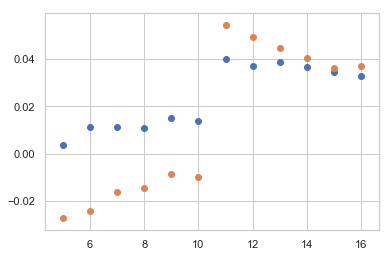

In [818]:
from sklearn.ensemble import RandomForestRegressor
y_tree_train = y_train.Global_Sales
y_tree_test = y_test.Global_Sales
rsqd_train = [] 
rsqd_test = []
depth = []

# for loop to loop over various parameters to improve model performance
for i in range(5, 17, 1):
    forest = RandomForestRegressor(n_estimators=i, max_depth=7, min_samples_split=2, min_samples_leaf=1,
                                   max_features=3, max_leaf_nodes=9, min_impurity_decrease=0, random_state=42)
    forest.fit(X_train, y_tree_train)
    rsqd_train.append(forest.score(X_train, y_tree_train))
    rsqd_test.append(forest.score(X_test, y_tree_test))
    depth.append(i)
    

plt.figure()
plt.scatter(depth, rsqd_train)
plt.scatter(depth, rsqd_test)
plt.show()

In [820]:
forest = RandomForestRegressor(n_estimators=11, max_depth=7, min_samples_split=2, min_samples_leaf=1,
                              max_features=3, max_leaf_nodes=9, min_impurity_decrease=0, random_state=42)
forest.fit(X_train, y_tree_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=3, max_leaf_nodes=9, min_impurity_decrease=0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=11, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [821]:
print('R^2 for forest train:', round(forest.score(X_train, y_train), 3))
print('R^2 for forest test:', round(forest.score(X_test, y_test), 3))

R^2 for forest train: 0.04
R^2 for forest test: 0.054


gradient boosted trees/gradient boosting regressor
randomforestregressor 

## Questions



